In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 75 # default for me was 75
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.model_selection import train_test_split, cross_validate
# The second one includes the Python wrapper? Not sure there is a real difference!
import xgboost as xgb
#from xgboost.sklearn import XGBClassifier
from xgboost import plot_importance
from sklearn.metrics import SCORERS, accuracy_score, precision_score, recall_score, roc_auc_score, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
# Removed StratifiedKFold, GridSearchCV,
from sklearn.model_selection import validation_curve

#conda install -c conda-forge shap
import shap
#Load JS visualisation code to Notebook
shap.initjs()

seed = 43

In [5]:
# label to evaluate
labelToEval = 'cityScore'

# As I am generating all the data I need to extract a decent set of data for eventual testing.
featuresDataFilename = 'ModelInput/features.csv'
labelsDataFilename = 'ModelInput/labels.csv'
# All feature and label data I have available
featuresDf = pd.read_csv(featuresDataFilename)
print('Features: {}'.format(featuresDf.shape))
labelsDf = pd.read_csv(labelsDataFilename)[['cityId', labelToEval]]
print('  Labels: {}'.format(labelsDf.shape))

# Merge the features and labels so I can extract the various sets
dataDf = pd.merge(featuresDf, labelsDf, on='cityId', how='inner')
print('Combined: {}'.format(dataDf.shape))

# Start at 2nd column, i.e. exclude cityId
allX = pd.get_dummies(dataDf.iloc[:,2:len(featuresDf.columns)])
print('\n   All X: {}'.format(allX.shape))
allY = dataDf[labelToEval]
print('   All y: {}'.format(allY.shape))

# Create train and test split values. 
# train will be split further using the StratifiedKFold random search below for parameter Opt...
trainX, testX, trainY, testY = train_test_split(allX, allY, test_size=0.20, random_state=seed)

print('\n  testX: {}'.format(testX.shape))
print('  testy: {}'.format(testy.shape))
print('\n trainX: {}'.format(trainX.shape))
print(' trainy: {}'.format(trainy.shape))

Features: (263, 36)
  Labels: (263, 2)
Combined: (263, 37)

   All X: (263, 34)
   All y: (263,)

  testX: (53, 34)
  testy: (53,)

 trainX: (210, 34)
 trainy: (210,)


In [6]:
# As I only have the top quantile at "good" I need to adjust the post weights!
# If i use ratio = 1 (default) I get zero good predictions
ratio = float(trainY.groupby(trainY).count()[0] / trainY.groupby(trainY).count()[1])
print('Est ratio: {:.3f}'.format(ratio))

Est ratio: 2.750


In [7]:
clf_xgb = xgb.XGBClassifier(objective='binary:logistic', scale_pos_weight=ratio)
param_dist = {
    'n_estimators': stats.randint(150, 500),
    'learning_rate': stats.uniform(0.05, 0.5),
    'subsample': stats.uniform(0.2, 0.8),
    'max_depth': [2, 3, 4, 5, 6],
    'colsample_bytree': stats.uniform(0.5, 0.45),
    'min_child_weight': [1, 2, 3]
}
clf = RandomizedSearchCV(clf_xgb, param_distributions = param_dist, n_iter = 20,
                         scoring='neg_log_loss', error_score = 0, verbose = 3, n_jobs = -1,
                         cv=5, iid=False, refit='neg_log_loss')

numFolds = 10
skf = StratifiedKFold(n_splits=numFolds)

estimators = []
results = np.zeros(len(trainX))
score = 0.0
for train_index, val_index in skf.split(trainX, trainY):
    X_train, X_val = trainX.iloc[train_index], trainX.iloc[val_index]
    y_train, y_val = trainY.iloc[train_index], trainY.iloc[val_index]
    clf.fit(X_train, y_train,
            eval_set = [(X_train, y_train), (X_val, y_val)],
            eval_metric= 'aucpr',
            verbose=40)
    
    estimators.append(clf.best_estimator_)
    results[val_index] = clf.predict(X_val)
    score += recall_score(y_val, results[val_index])
score /= numFolds
# Fitting (cv=5) folds for each of (n_iter=20) candidates

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   25.4s finished


[0]	validation_0-aucpr:0.488051	validation_1-aucpr:0.777778
[40]	validation_0-aucpr:0.882491	validation_1-aucpr:0.493959
[80]	validation_0-aucpr:0.939827	validation_1-aucpr:0.380266
[120]	validation_0-aucpr:0.957786	validation_1-aucpr:0.415129
[160]	validation_0-aucpr:0.969254	validation_1-aucpr:0.464935
[161]	validation_0-aucpr:0.968053	validation_1-aucpr:0.464935
Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   23.7s finished


[0]	validation_0-aucpr:0.466622	validation_1-aucpr:0.626004
[40]	validation_0-aucpr:0.903826	validation_1-aucpr:0.71703
[80]	validation_0-aucpr:0.929055	validation_1-aucpr:0.683002
[120]	validation_0-aucpr:0.95226	validation_1-aucpr:0.603478
[160]	validation_0-aucpr:0.962913	validation_1-aucpr:0.611073
[200]	validation_0-aucpr:0.973417	validation_1-aucpr:0.632204
[240]	validation_0-aucpr:0.982189	validation_1-aucpr:0.632204
[268]	validation_0-aucpr:0.97822	validation_1-aucpr:0.661209
Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   24.1s finished


[0]	validation_0-aucpr:0.320131	validation_1-aucpr:0.220864
[40]	validation_0-aucpr:0.7734	validation_1-aucpr:0.38206
[80]	validation_0-aucpr:0.808797	validation_1-aucpr:0.503134
[120]	validation_0-aucpr:0.821851	validation_1-aucpr:0.619321
[160]	validation_0-aucpr:0.828743	validation_1-aucpr:0.670032
[200]	validation_0-aucpr:0.837983	validation_1-aucpr:0.636096
[210]	validation_0-aucpr:0.845619	validation_1-aucpr:0.446545
Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   23.9s finished


[0]	validation_0-aucpr:0.348697	validation_1-aucpr:0.262498
[40]	validation_0-aucpr:0.859336	validation_1-aucpr:0.291572
[80]	validation_0-aucpr:0.890188	validation_1-aucpr:0.438458
[120]	validation_0-aucpr:0.906039	validation_1-aucpr:0.434841
[160]	validation_0-aucpr:0.914992	validation_1-aucpr:0.465987
[200]	validation_0-aucpr:0.912152	validation_1-aucpr:0.358188
[240]	validation_0-aucpr:0.927972	validation_1-aucpr:0.361117
[280]	validation_0-aucpr:0.919925	validation_1-aucpr:0.344397
[295]	validation_0-aucpr:0.922234	validation_1-aucpr:0.343773
Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   25.3s finished


[0]	validation_0-aucpr:0.338991	validation_1-aucpr:0.345889
[40]	validation_0-aucpr:0.836678	validation_1-aucpr:0.73701
[80]	validation_0-aucpr:0.95124	validation_1-aucpr:0.698523
[120]	validation_0-aucpr:0.980684	validation_1-aucpr:0.58252
[160]	validation_0-aucpr:0.982806	validation_1-aucpr:0.55487
[200]	validation_0-aucpr:0.990068	validation_1-aucpr:0.49063
[240]	validation_0-aucpr:0.99183	validation_1-aucpr:0.526342
[280]	validation_0-aucpr:0.994763	validation_1-aucpr:0.542644
[307]	validation_0-aucpr:0.999223	validation_1-aucpr:0.56341
Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   25.8s finished


[0]	validation_0-aucpr:0.53657	validation_1-aucpr:0.791023
[40]	validation_0-aucpr:0.950039	validation_1-aucpr:0.669374
[80]	validation_0-aucpr:0.995822	validation_1-aucpr:0.484897
[120]	validation_0-aucpr:1	validation_1-aucpr:0.490898
[160]	validation_0-aucpr:1	validation_1-aucpr:0.487726
[194]	validation_0-aucpr:1	validation_1-aucpr:0.490898
Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   19.7s finished


[0]	validation_0-aucpr:0.395704	validation_1-aucpr:0.625
[40]	validation_0-aucpr:0.604187	validation_1-aucpr:0.451889
[80]	validation_0-aucpr:0.676167	validation_1-aucpr:0.650456
[120]	validation_0-aucpr:0.728293	validation_1-aucpr:0.678756
[160]	validation_0-aucpr:0.722446	validation_1-aucpr:0.618735
[200]	validation_0-aucpr:0.709994	validation_1-aucpr:0.711987
[240]	validation_0-aucpr:0.725276	validation_1-aucpr:0.650456
[280]	validation_0-aucpr:0.719406	validation_1-aucpr:0.678756
[320]	validation_0-aucpr:0.730294	validation_1-aucpr:0.646457
[322]	validation_0-aucpr:0.734295	validation_1-aucpr:0.646457
Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   23.1s finished


[0]	validation_0-aucpr:0.430916	validation_1-aucpr:0.191566
[40]	validation_0-aucpr:0.795021	validation_1-aucpr:0.213838
[80]	validation_0-aucpr:0.819239	validation_1-aucpr:0.216401
[120]	validation_0-aucpr:0.818997	validation_1-aucpr:0.238628
[160]	validation_0-aucpr:0.866055	validation_1-aucpr:0.215819
[200]	validation_0-aucpr:0.860634	validation_1-aucpr:0.23082
[240]	validation_0-aucpr:0.874692	validation_1-aucpr:0.205725
[278]	validation_0-aucpr:0.883532	validation_1-aucpr:0.208217
Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   25.5s finished


[0]	validation_0-aucpr:0.404407	validation_1-aucpr:0.577024
[40]	validation_0-aucpr:0.836737	validation_1-aucpr:0.590618
[80]	validation_0-aucpr:0.871327	validation_1-aucpr:0.609393
[120]	validation_0-aucpr:0.915413	validation_1-aucpr:0.682637
[160]	validation_0-aucpr:0.935033	validation_1-aucpr:0.575291
[200]	validation_0-aucpr:0.9441	validation_1-aucpr:0.585266
[240]	validation_0-aucpr:0.949486	validation_1-aucpr:0.575291
[280]	validation_0-aucpr:0.947009	validation_1-aucpr:0.591374
[283]	validation_0-aucpr:0.95134	validation_1-aucpr:0.58724
Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   23.0s finished


[0]	validation_0-aucpr:0.553387	validation_1-aucpr:0.241677
[40]	validation_0-aucpr:0.941674	validation_1-aucpr:0.745499
[80]	validation_0-aucpr:0.971265	validation_1-aucpr:0.760401
[120]	validation_0-aucpr:0.989382	validation_1-aucpr:0.778803
[160]	validation_0-aucpr:0.99385	validation_1-aucpr:0.765107
[162]	validation_0-aucpr:0.99385	validation_1-aucpr:0.765107


In [11]:
#RandomizedSearchCV?

# estimators has "models"
# results = total dataset prediction (from out-of-fold?)
# score has estimate of the "recall score"

i=0
for estimator in estimators:
    print('\n\n\nMetrics for estimator {}:'.format(i))
    i = i + 1
    y_pred = estimator.predict(testX)
    y_pred_prob = clf.predict_proba(testX)
    predROC = clf.predict_proba(testX)[:,1]

    accuracy = accuracy_score(testY, y_pred)
    precision=precision_score(testY, y_pred)
    recall=recall_score(testY, y_pred)
    roc=roc_auc_score(testY,predROC)

    print('  Accuracy:  {:.3f}'.format(accuracy))
    print('     Error:  {:.3f}'.format(1 - accuracy))
    print(' Precision:  {:.3f}'.format(precision))
    print('       AUC:  {:.3f}'.format(roc))
    print('')
    print('    Recall:  {:.3f}'.format(recall))
    print('')
    print(pd.crosstab(
        pd.Series(testY.values, name='Actual'),
        pd.Series(y_pred, name='Predicted'),
        margins=True
    ))




Metrics for estimator 0:
  Accuracy:  0.698
     Error:  0.302
 Precision:  0.316
       AUC:  0.750

    Recall:  0.667

Predicted  0.0  1.0  All
Actual                  
0.0         31   13   44
1.0          3    6    9
All         34   19   53



Metrics for estimator 1:
  Accuracy:  0.660
     Error:  0.340
 Precision:  0.263
       AUC:  0.750

    Recall:  0.556

Predicted  0.0  1.0  All
Actual                  
0.0         30   14   44
1.0          4    5    9
All         34   19   53



Metrics for estimator 2:
  Accuracy:  0.642
     Error:  0.358
 Precision:  0.188
       AUC:  0.750

    Recall:  0.333

Predicted  0.0  1.0  All
Actual                  
0.0         31   13   44
1.0          6    3    9
All         37   16   53



Metrics for estimator 3:
  Accuracy:  0.660
     Error:  0.340
 Precision:  0.263
       AUC:  0.750

    Recall:  0.556

Predicted  0.0  1.0  All
Actual                  
0.0         30   14   44
1.0          4    5    9
All         34   19   53


In [16]:
# Re-write above code to sort by Recall, then Accuracy and select top estimator for "next" steps!

# Choosing estimator number 7 as has best recall and accuracy combination

clf = estimators[7]
print(clf.get_params)

<bound method XGBModel.get_params of XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.7809918177962447, gamma=0,
       learning_rate=0.08163145916350602, max_delta_step=0, max_depth=2,
       min_child_weight=2, missing=None, n_estimators=279, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=2.75, seed=None,
       silent=True, subsample=0.20242358000646776)>


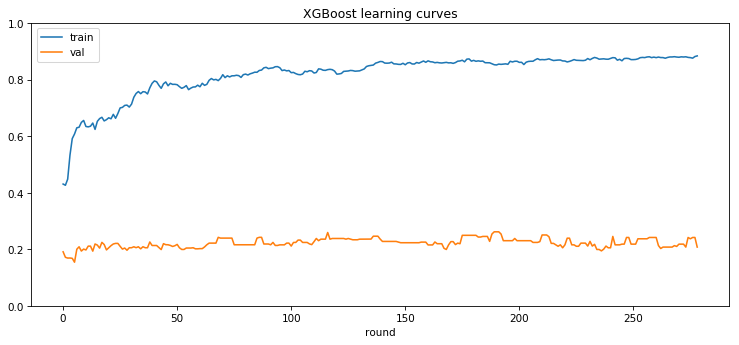

In [14]:
#evals_result = clf.evals_result()
#train_errors = evals_result['validation_0']['aucpr']
#validation_errors = evals_result['validation_1']['aucpr']
#df = pd.DataFrame([train_errors, validation_errors]).T
#df.columns = ['train', 'val']
#df.index.name = 'round'
#df.plot(title='XGBoost learning curves', ylim=(0.0,1.0), figsize=(12,5))

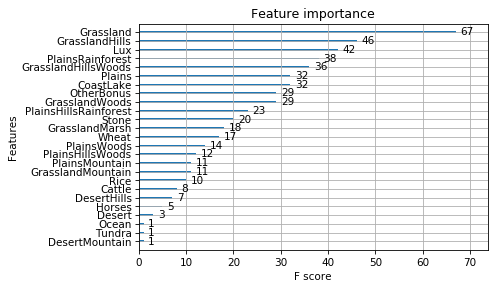

In [17]:
plot_importance(clf)
plt.rcParams['figure.figsize'] = [12, 8]
plt.show()

In [18]:
# Explain model's predictions using SHAP values
# same syntax works for LightGBM, CatBoost, and scikit-learn models)
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(allX)

print('Base SHAP value: {:.4f}'.format(explainer.expected_value))

Base SHAP value: 3.4780


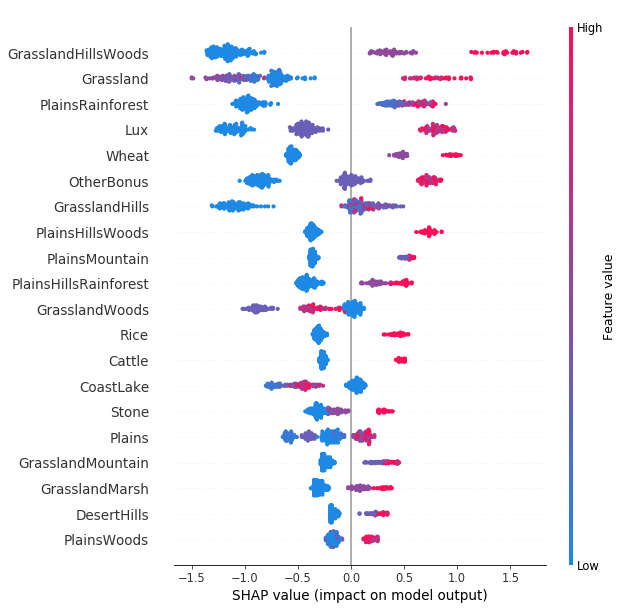

In [19]:
shap.summary_plot(shap_values, allX)

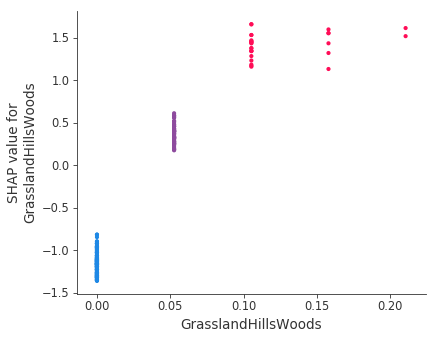

In [20]:
idx1 = allX.columns.get_loc('GrasslandHillsWoods')
idx2 = allX.columns.get_loc('GrasslandHillsWoods')
shap.dependence_plot(idx1, shap_values, allX, None, None, idx2)

In [29]:
featuresOfInterest = ['Grassland', 'Plains', 'PlainsMountain', 'Stone', 'GrasslandHillsWoods',
                      'PlainsRainforest', 'OtherBonus', 'PlainsWoods', 'PlainsHillsRainforest',
                      'Rice', 'GrasslandHills', 'CoastLake', 'GrasslandWoods', 'Wheat',
                      'PlainsHillsWoods', 'Lux', 'Horses', 'CoastLakeReef']
for f in featuresOfInterest:
    print("{:>22} :- Min: {:.4f}  Max: {:.4f}  Mean: {:.4f}".format(f,
        allX[f].min(),
        allX[f].max(),
        allX[f].mean()))
    
# Misleading information as the data is highly skewed towards 0! (And I think shapley values are per city, not per feature?)

             Grassland :- Min: 0.0000  Max: 0.7895  Mean: 0.1737
                Plains :- Min: 0.0000  Max: 0.7895  Mean: 0.1349
        PlainsMountain :- Min: 0.0000  Max: 0.2632  Mean: 0.0236
                 Stone :- Min: 0.0000  Max: 0.2105  Mean: 0.0278
   GrasslandHillsWoods :- Min: 0.0000  Max: 0.2105  Mean: 0.0246
      PlainsRainforest :- Min: 0.0000  Max: 0.7368  Mean: 0.0640
            OtherBonus :- Min: 0.0000  Max: 0.2105  Mean: 0.0448
           PlainsWoods :- Min: 0.0000  Max: 0.2632  Mean: 0.0376
 PlainsHillsRainforest :- Min: 0.0000  Max: 0.3158  Mean: 0.0252
                  Rice :- Min: 0.0000  Max: 0.1579  Mean: 0.0128
        GrasslandHills :- Min: 0.0000  Max: 0.5789  Mean: 0.0841
             CoastLake :- Min: 0.0000  Max: 0.6842  Mean: 0.1081
        GrasslandWoods :- Min: 0.0000  Max: 0.3684  Mean: 0.0520
                 Wheat :- Min: 0.0000  Max: 0.1579  Mean: 0.0212
      PlainsHillsWoods :- Min: 0.0000  Max: 0.2105  Mean: 0.0146
                   Lux :-

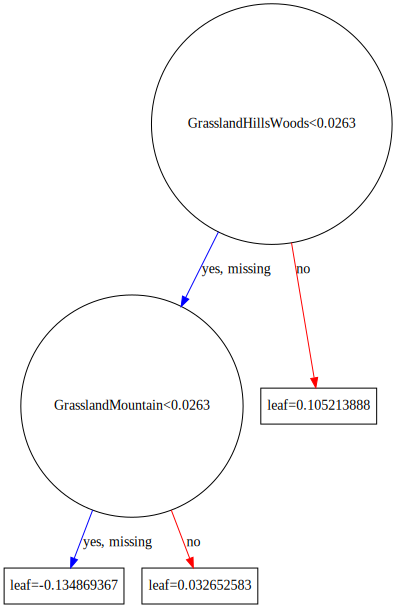

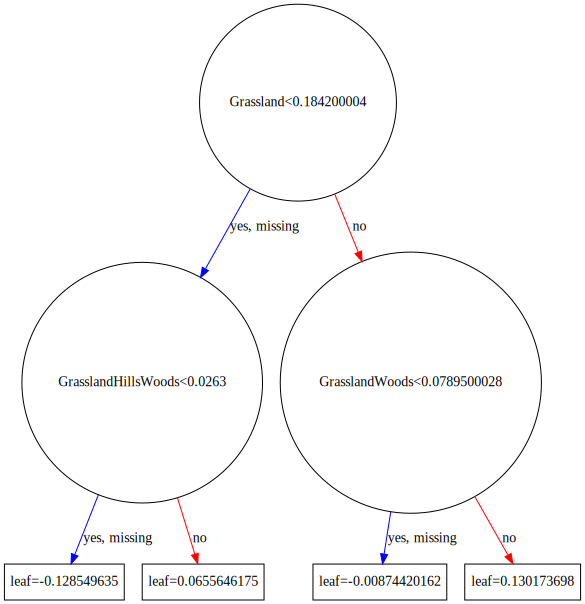

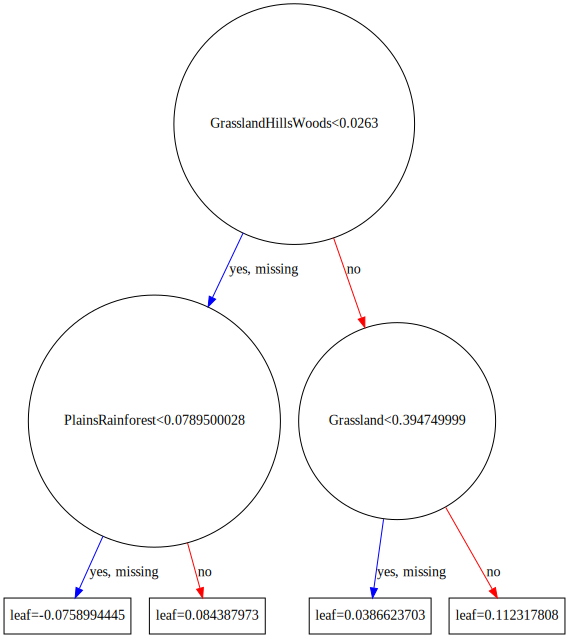

In [22]:
display(xgb.to_graphviz(clf, num_trees=0))
display(xgb.to_graphviz(clf, num_trees=1))
display(xgb.to_graphviz(clf, num_trees=2))
#display(xgb.to_graphviz(clf, num_trees=3))
#display(xgb.to_graphviz(clf, num_trees=4))
#display(xgb.to_graphviz(clf, num_trees=5))
#display(xgb.to_graphviz(clf, num_trees=6))
#display(xgb.to_graphviz(clf, num_trees=7))
#display(xgb.to_graphviz(clf, num_trees=8))
#display(xgb.to_graphviz(clf, num_trees=9))

In [23]:
clf.get_booster().dump_model('test-model-output.json', with_stats=True, dump_format='json')